In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2

import keras
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import Model
from keras import backend as K
from keras.layers.core import Lambda
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import random

import tensorflow as tf


Using TensorFlow backend.


In [0]:
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Get Data

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
path = '/content/drive/My Drive/project/data_main/'

In [0]:
train_img = path + "train_images"

In [10]:
train_data  = pd.read_csv(path + '/train.csv')
print("Length of train data", len(train_data))

Length of train data 50272


In [0]:
# Pivot the data
df = pd.read_csv(path + '/train.csv')
df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)
# Divide the data 
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69) 

In [0]:
train_df = train_df.reset_index()
train_df = train_df.reset_index()

val_df = val_df.reset_index()
val_df = val_df.reset_index()
 

In [13]:
# For class imbalance, we need to use the data witout nulls.
df_no_null = train_data[train_data['EncodedPixels'].notnull()].reset_index(drop=True)
 
print("Lenght of training data " , len(train_df))
print("Lenght of validation data " , len(val_df))

Lenght of training data  10054
Lenght of validation data  2514



# Pre-process data

In [0]:
def mask2rle(img):
    '''
    For an ouput numpy array
    1  == Mask, 
    0  == background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:

def make_mask(row_id, df):
    '''
    Given a row index, 
    return a image id and mask of the image in the format of (256, 1600, 4)
    from the dataframe `df`
    '''

    masks = np.zeros((256, 1600, 4), dtype=np.float32)     
    labels = df.iloc[row_id][2:-1]
    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return masks

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size=16,
                 img_h=256, img_w=256, shuffle=True):
        
        self.df = df
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.df)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = indexes
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_temp):
      img_size = 256
      x_batch = []
      y_batch = []
      for id in list_ids_temp: 
          # Get the image
          image_name = self.df['ImageId'].iloc[id]
          image = cv2.imread(self.image_dir  + 'train_images/'+image_name)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
          # Get the mask 
          mask = make_mask(id, self.df)
          # Resize 
          image = cv2.resize(image, (img_size, img_size))
          mask = cv2.resize(mask, (img_size, img_size))
          # Add 
          x_batch += [image]
          y_batch += [mask]
      # Change to numpy                   
      x_batch = np.array(x_batch)
      y_batch = np.array(y_batch)
      return x_batch, y_batch

In [0]:
training_generator = DataGenerator(train_df, path)

In [0]:
validation_generator = DataGenerator(val_df, path) 

In [0]:
def class_imbalance(df): 
  '''
  To treat for class imbalance, we will be using this function
  '''
  # Get the data, arrange it in classes 
  df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
  df['ClassId'] = df['ClassId'].astype(int)
  df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
  df['defects'] = df.count(axis=1) 
  # Get the number of mask in each class 
  list_all = list(df.count())[: -1]
  sum_list_all = sum(list_all) 
  return [list_all[i]/sum_list_all * 4  for i in range(len(list_all))] 

# Model

In [0]:
def dsc(y_true, y_pred, smooth=1):
    '''
    Get the dice coefficiant of two oututs 
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth) 
  
def dice_loss(y_true, y_pred):
    '''
    Get the loss 
    '''
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    '''
    Get the loss
    '''
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss  

In [21]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights=None, input_shape=(256,256,3), include_top=False)
base_model.trainable = True
base_out = base_model.output
up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(4, (1, 1))(up)
conv = Activation('sigmoid')(conv)
model = Model(input=base_model.input, output=conv)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics = [dsc])
 







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  


# Test & Train

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(path + 'model_best_weights_vgg_nfrozen.h5', monitor='loss', verbose=1, save_best_only=False, mode='min', period=1) 

In [23]:
batch_size = 16
results = model.fit_generator(generator=training_generator, 
                              validation_data=validation_generator,
                              class_weight=class_imbalance(df_no_null),  
                              steps_per_epoch= 100,
                              epochs=50, callbacks = [checkpoint],) 




Epoch 1/50





100/100 [==============================] - 1493s 15s/step - loss: 1.1174 - dsc: 0.0337 - val_loss: 1.0062 - val_dsc: 0.0326

Epoch 00001: saving model to /content/drive/My Drive/project/data_main/model_best_weights_vgg_nfrozen.h5
Epoch 2/50
100/100 [==============================] - 597s 6s/step - loss: 1.0559 - dsc: 0.0385 - val_loss: 1.0037 - val_dsc: 0.0450

Epoch 00002: saving model to /content/drive/My Drive/project/data_main/model_best_weights_vgg_nfrozen.h5
Epoch 3/50
100/100 [==============================] - 627s 6s/step - loss: 1.0070 - dsc: 0.0401 - val_loss: 0.9972 - val_dsc: 0.0455

Epoch 00003: saving model to /content/drive/My Drive/project/data_main/model_best_weights_vgg_nfrozen.h5
Epoch 4/50
100/100 [==============================] - 610s 6s/step - loss: 1.0056 - dsc: 0.0512 - val_loss: 1.0049 - val_dsc: 0.0449

Epoch 00004: saving model to /content/drive/My Drive/project/data_main/model_best_weights_vgg_nfrozen.h5
Epoch 5/50
100/100 [==============

# Output & Visulisation

In [0]:
history = results


dict_keys(['val_loss', 'val_dsc', 'loss', 'dsc'])


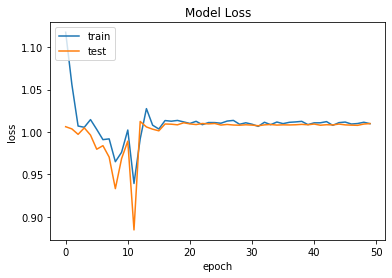

In [25]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_dsc', 'loss', 'dsc'])


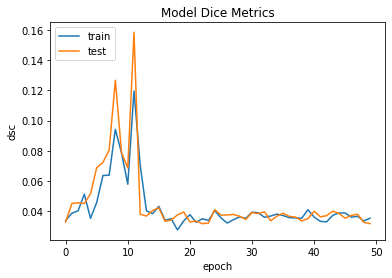

In [26]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['dsc'])
plt.plot(history.history['val_dsc'])
plt.title('Model Dice Metrics')
plt.ylabel('dsc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
results_output = pd.DataFrame()

In [0]:
results_output["Epoch"] = list(range(1,51))
results_output['Loss'] = history.history['loss']
results_output['Dice Metrics'] = history.history['dsc'] 
results_output['Validation Loss'] = history.history['val_loss'] 
results_output['Validation Dice Metrics'] = history.history['val_dsc'] 


In [0]:
results_output  = results_output.round(3) 

In [30]:
results_output

,Epoch,Loss,Dice Metrics,Validation Loss,Validation Dice Metrics
0,1,1.117,0.034,1.006,0.033
1,2,1.056,0.038,1.004,0.045
2,3,1.007,0.040,0.997,0.045
3,4,1.006,0.051,1.005,0.045
4,5,1.015,0.035,0.996,0.051
5,6,1.003,0.046,0.980,0.069
6,7,0.991,0.064,0.984,0.072
7,8,0.992,0.064,0.970,0.080
8,9,0.965,0.094,0.933,0.127
9,10,0.976,0.078,0.969,0.079


In [0]:
results_output.to_csv(path + "SDA_VGG16_NFrozen.csv")